# **Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

In [2]:
import kagglehub

path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import WeightedRandomSampler
import torch.optim as optim

### Data Preparation

In [4]:
def stratified_splits(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    image_paths = []
    labels = []
    for root, dirs, files in os.walk(root_dir):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                parts = filename.split('_')
                if len(parts) > 1:
                    image_paths.append(os.path.join(root, filename))
                    labels.append(parts[0]) # "01"
    
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, labels, test_size=(1 - train_ratio), 
        stratify=labels, random_state=seed
    )
   
    rel_test_size = test_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=rel_test_size, 
        stratify=y_temp, random_state=seed
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


class HorseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.breed_to_idx = {f"{i:02d}": i-1 for i in range(1, 8)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.breed_to_idx[self.labels[idx]]
        return image, torch.tensor(label, dtype=torch.long)


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


X_train, X_val, X_test, y_train, y_val, y_test = stratified_splits(path)


train_ds = HorseDataset(X_train, y_train, transform=train_transforms)
val_ds = HorseDataset(X_val, y_val, transform=test_transforms)
test_ds = HorseDataset(X_test, y_test, transform=test_transforms)


print("Calculating weights for balancing...")
targets = [train_ds.breed_to_idx[lab] for lab in y_train]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


batch_size = 32
train_dataloader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=2)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Data ready: {len(X_train)} Train, {len(X_val)} Val, {len(X_test)} Test samples.")

Calculating weights for balancing...
Data ready: 468 Train, 101 Val, 101 Test samples.


#### Display some images

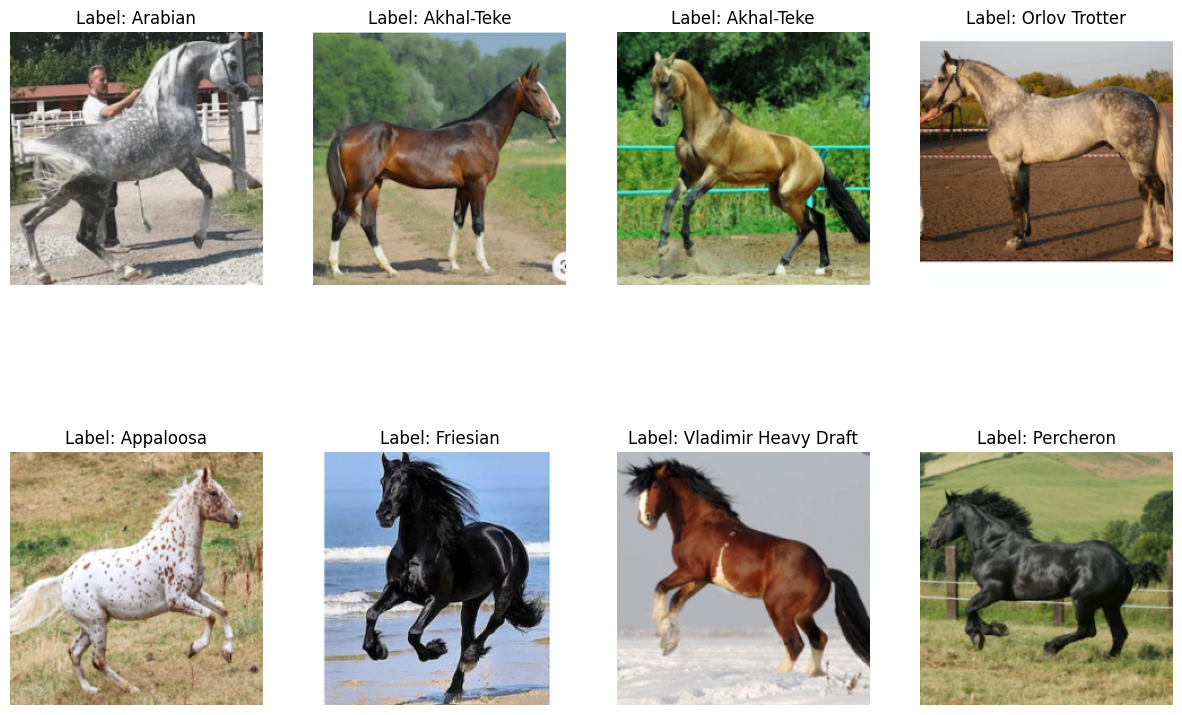

In [5]:
def show_batch(test_dataloader, breed_map):
   
    images, labels = next(iter(test_dataloader))
    
    
    plt.figure(figsize=(15, 10))
    
   
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        
        
        img = images[i].numpy().transpose((1, 2, 0))
        
      
        img = std * img + mean
        img = np.clip(img, 0, 1) 
        
        
        label_idx = labels[i].item()
        breed_code = f"{label_idx + 1:02d}"
        breed_name = breed_map.get(breed_code, "Unknown")
        
        plt.imshow(img)
        plt.title(f"Label: {breed_name}")
        plt.axis('off')


breeds_dict = {
    "01": "Akhal-Teke", "02": "Appaloosa", "03": "Orlov Trotter",
    "04": "Vladimir Heavy Draft", "05": "Percheron", "06": "Arabian", "07": "Friesian"
}


show_batch(test_dataloader, breeds_dict)
plt.show()

### Loss function and Optimizer and scheduler

In [6]:
def training_tools(model, lr=1e-4):
    loss_function = nn.CrossEntropyLoss()
    
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                           lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
    return loss_function, optimizer, scheduler

#### Train_function

In [7]:
def train_function(model, dataloader, loss_function, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    avg_loss = running_loss / len(dataloader.dataset)
    avg_acc = 100.0 * correct / total
    return avg_loss, avg_acc

#### Validation function  

In [8]:

def validate_function(model, dataloader, loss_function, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = running_loss / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = 100.0 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
    return avg_loss, accuracy, f1

### Test Function

In [9]:
def test_function(model, dataloader, device):
    
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = 100.0 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
    
    print(f"\n--- Final Test Results ---")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test F1-Score: {f1:.4f}")
    return accuracy, f1

### Visualization

In [10]:
import matplotlib.pyplot as plt

def plot_history(history, model_name="Model"):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Val Loss')
    plt.title(f'{model_name} - Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'y-o', label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], 'g-o', label='Val Accuracy')
    plt.title(f'{model_name} - Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Visualize Predictions

In [11]:
def visualize_predictions(model, dataloader, device, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 10))

    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                images_so_far += 1
                ax = plt.subplot((num_images + 2) // 3, 3, images_so_far)
                ax.axis('off')
                
                color = 'green' if preds[i] == labels[i] else 'red'
                
                
                img = images.cpu().data[i].numpy().transpose((1, 2, 0))
                
                
                img = std * img + mean
                img = np.clip(img, 0, 1) 
                
                ax.set_title(f'Pred: {class_names[preds[i]]}\nActual: {class_names[labels[i]]}', color=color)
                plt.imshow(img)

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

### Algorithm 1 - CNN (From Scratch)

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        # Input size: 128 channels * 28 * 28 = 100352
        self.fc1 = nn.Linear(100352, 1024) 
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu5(x)
        
        x = self.fc3(x)
        return x

In [19]:
def print_data_flow(model):
    
    x = torch.randn(1, 3, 224, 224) 
    
    print(f"Input shape: \t\t{x.shape}")

  
    x = model.conv1(x)
    x = model.relu1(x)
    x = model.pool1(x)
    print(f"After Block 1: \t\t{x.shape}")

    x = model.conv2(x)
    x = model.relu2(x)
    x = model.pool2(x)
    print(f"After Block 2: \t\t{x.shape}")

    x = model.conv3(x)
    x = model.relu3(x)
    x = model.pool3(x)
    print(f"After Block 3: \t\t{x.shape}")

    x = model.flatten(x)
    print(f"After Flatten: \t\t{x.shape}")

    x = model.fc1(x)
    x = model.relu4(x)
    x = model.dropout(x)
    print(f"After FC1: \t\t{x.shape}")

    x = model.fc2(x)
    x = model.relu5(x)
    x = model.fc3(x)
    print(f"Output (7 classes): \t{x.shape}")

In [20]:
num_classes = 7 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cnn = SimpleCNN(num_classes).to(device)

print("--- Tracing Data Flow ---")

print_data_flow(model_cnn.cpu()) 
model_cnn.to(device) 


--- Tracing Data Flow ---
Input shape: 		torch.Size([1, 3, 224, 224])
After Block 1: 		torch.Size([1, 32, 112, 112])
After Block 2: 		torch.Size([1, 64, 56, 56])
After Block 3: 		torch.Size([1, 128, 28, 28])
After Flatten: 		torch.Size([1, 100352])
After FC1: 		torch.Size([1, 1024])
Output (7 classes): 	torch.Size([1, 7])


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu5): ReLU()
  (fc3): Linear(in_features=512, out_features=7, bias=True)
)

Starting Training 

Epoch 1/10:
Train Loss: 2.4595 | Train Accuracy: 20.09%
Val Loss: 1.8482 | Val Accuracy: 23.76% | Model Saved 
------------------------------
Epoch 2/10:
Train Loss: 1.6290 | Train Accuracy: 38.46%
Val Loss: 1.4815 | Val Accuracy: 38.61% | Model Saved 
------------------------------
Epoch 3/10:
Train Loss: 1.3985 | Train Accuracy: 46.58%
Val Loss: 1.4283 | Val Accuracy: 40.59% | Model Saved 
------------------------------
Epoch 4/10:
Train Loss: 1.2479 | Train Accuracy: 54.06%
Val Loss: 1.4594 | Val Accuracy: 51.49%
------------------------------
Epoch 5/10:
Train Loss: 1.0856 | Train Accuracy: 61.54%
Val Loss: 1.1996 | Val Accuracy: 60.40% | Model Saved 
------------------------------
Epoch 6/10:
Train Loss: 0.9155 | Train Accuracy: 66.24%
Val Loss: 1.2042 | Val Accuracy: 58.42%
------------------------------
Epoch 7/10:
Train Loss: 0.8769 | Train Accuracy: 69.23%
Val Loss: 1.1323 | Val Accuracy: 58.42% | Model Saved 
------------------------------
Epoch 8/10:
Trai

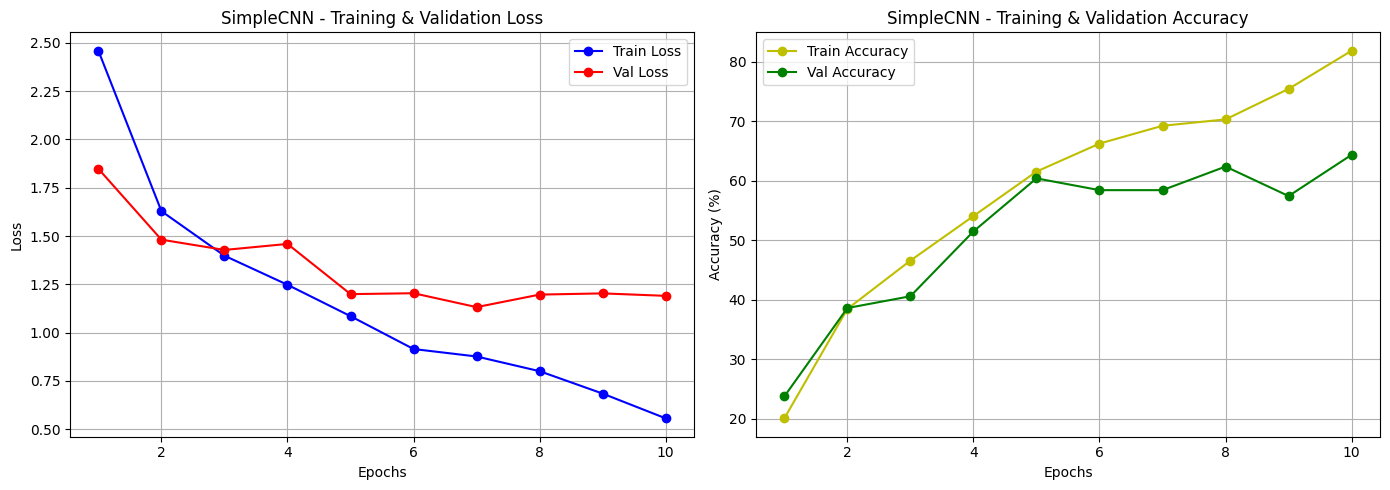

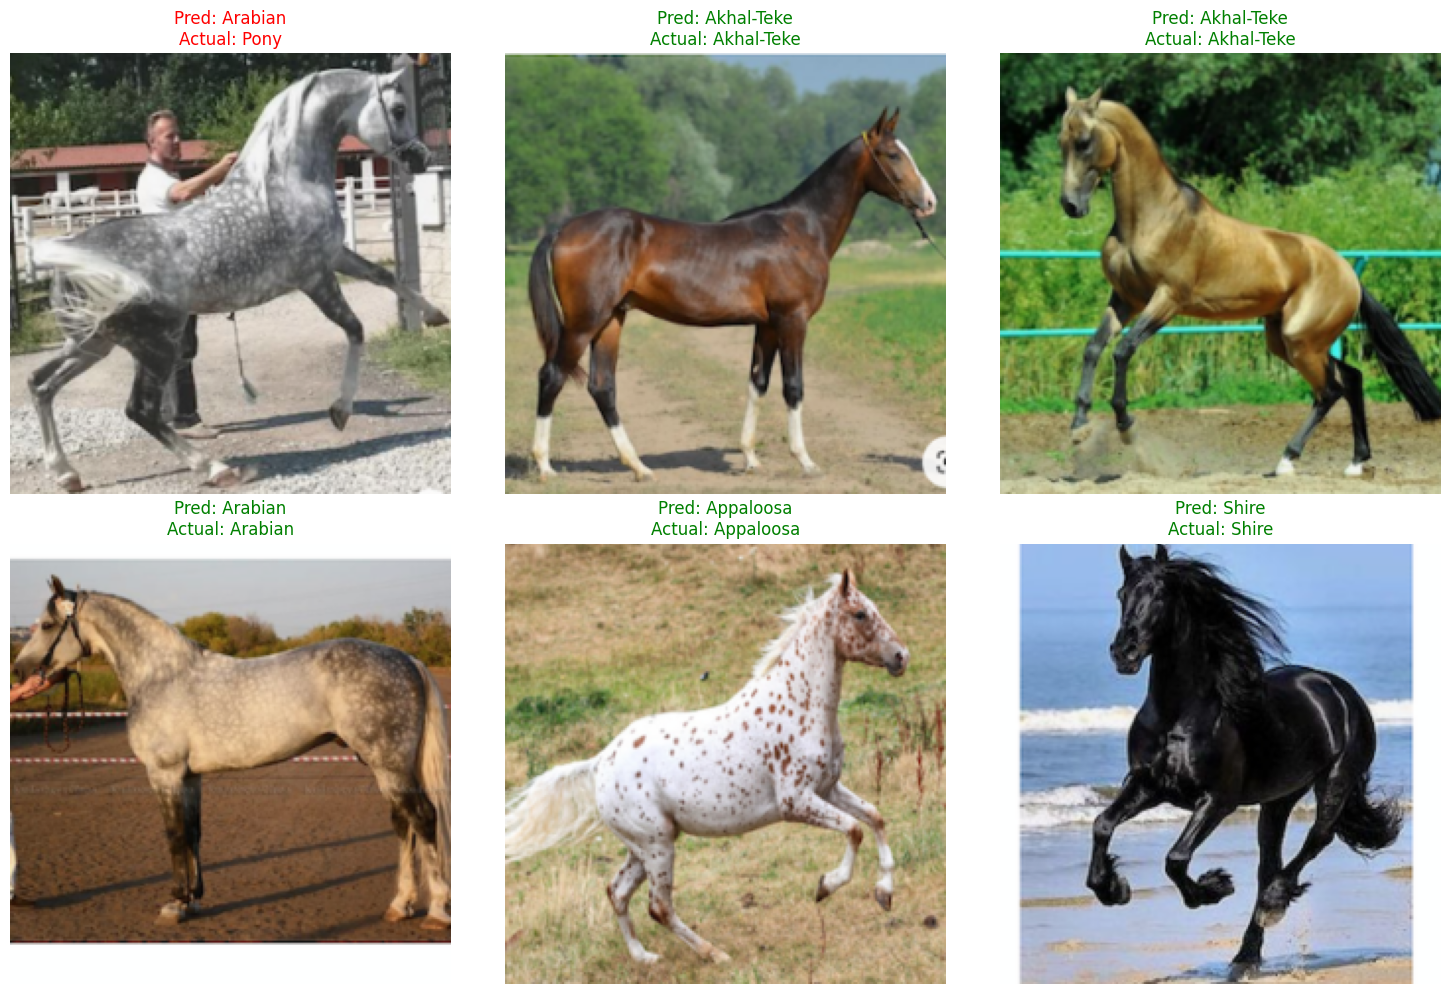

In [21]:
loss_fn_cnn, opt_cnn, sched_cnn = training_tools(model_cnn, lr=1e-3)

cnn_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_loss = float('inf')  
horse_breeds = ['Akhal-Teke', 'Appaloosa', 'Arabian', 'Friesian', 'Percheron', 'Pony', 'Shire']

print(f"Starting Training \n")

for epoch in range(10):
    t_loss, t_acc = train_function(model_cnn, train_dataloader, loss_fn_cnn, opt_cnn, device)
    v_loss, v_acc, v_f1 = validate_function(model_cnn, val_dataloader, loss_fn_cnn, device)
    
    sched_cnn.step()

    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(model_cnn.state_dict(), 'best_simple_cnn.pth')
        save_msg = f" | Model Saved "
    else:
        save_msg = ""

    cnn_history['train_loss'].append(t_loss)
    cnn_history['train_acc'].append(t_acc)
    cnn_history['val_loss'].append(v_loss)
    cnn_history['val_acc'].append(v_acc)
    cnn_history['val_f1'].append(v_f1)
    
    print(f"Epoch {epoch+1}/10:")
    print(f"Train Loss: {t_loss:.4f} | Train Accuracy: {t_acc:.2f}%")
    print(f"Val Loss: {v_loss:.4f} | Val Accuracy: {v_acc:.2f}%{save_msg}")
    print("-" * 30)

print("\n--- Final Evaluation ---")
model_cnn.load_state_dict(torch.load('best_simple_cnn.pth'))
test_acc, test_f1 = test_function(model_cnn, test_dataloader, device)


plot_history(cnn_history, "SimpleCNN")



visualize_predictions(model_cnn, test_dataloader, device, horse_breeds)

### Algorithm 2 - Vision Transformer (ViT)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vit = models.vit_b_16(weights='DEFAULT').to(device)


for param in model_vit.parameters():
    param.requires_grad = False


model_vit.heads = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 7) 
).to(device)

print("ViT Model initialized.")

ViT Model initialized.


Starting Training 

Epoch 1/10:
Train Loss: 1.8447 | Train Accuracy: 36.97%
Val Loss: 1.6838 | Val Accuracy: 62.38% | Model Saved
------------------------------
Epoch 2/10:
Train Loss: 1.5540 | Train Accuracy: 66.67%
Val Loss: 1.4576 | Val Accuracy: 71.29% | Model Saved
------------------------------
Epoch 3/10:
Train Loss: 1.3584 | Train Accuracy: 67.74%
Val Loss: 1.2666 | Val Accuracy: 71.29% | Model Saved
------------------------------
Epoch 4/10:
Train Loss: 1.1601 | Train Accuracy: 74.15%
Val Loss: 1.0904 | Val Accuracy: 82.18% | Model Saved
------------------------------
Epoch 5/10:
Train Loss: 1.0060 | Train Accuracy: 74.57%
Val Loss: 0.9391 | Val Accuracy: 86.14% | Model Saved
------------------------------
Epoch 6/10:
Train Loss: 0.9225 | Train Accuracy: 78.63%
Val Loss: 0.8373 | Val Accuracy: 90.10% | Model Saved
------------------------------
Epoch 7/10:
Train Loss: 0.8009 | Train Accuracy: 82.69%
Val Loss: 0.7541 | Val Accuracy: 88.12% | Model Saved
------------------------

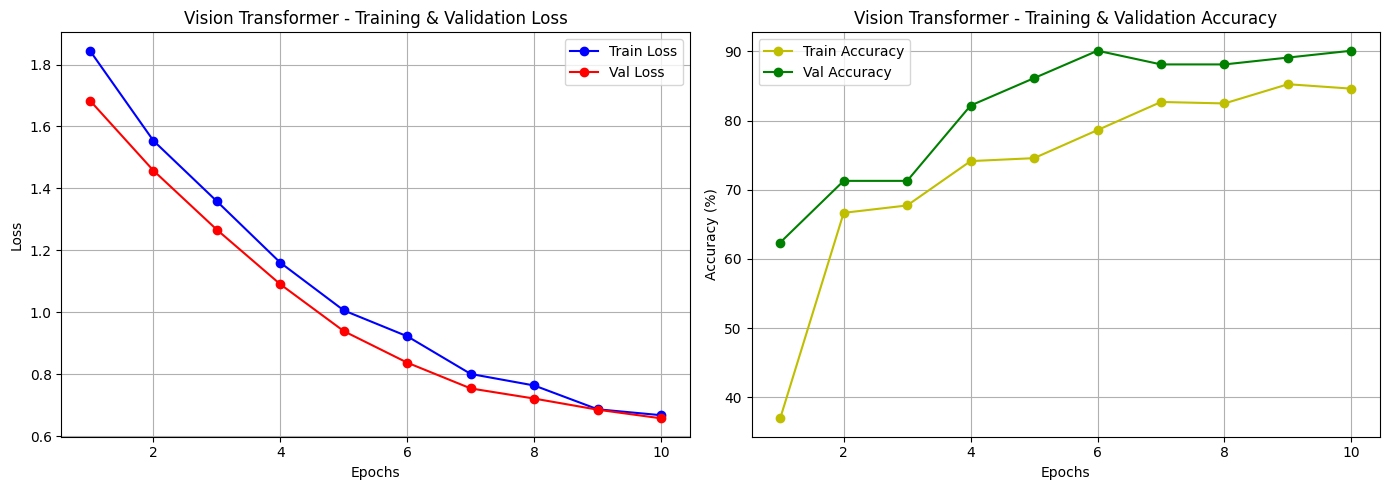

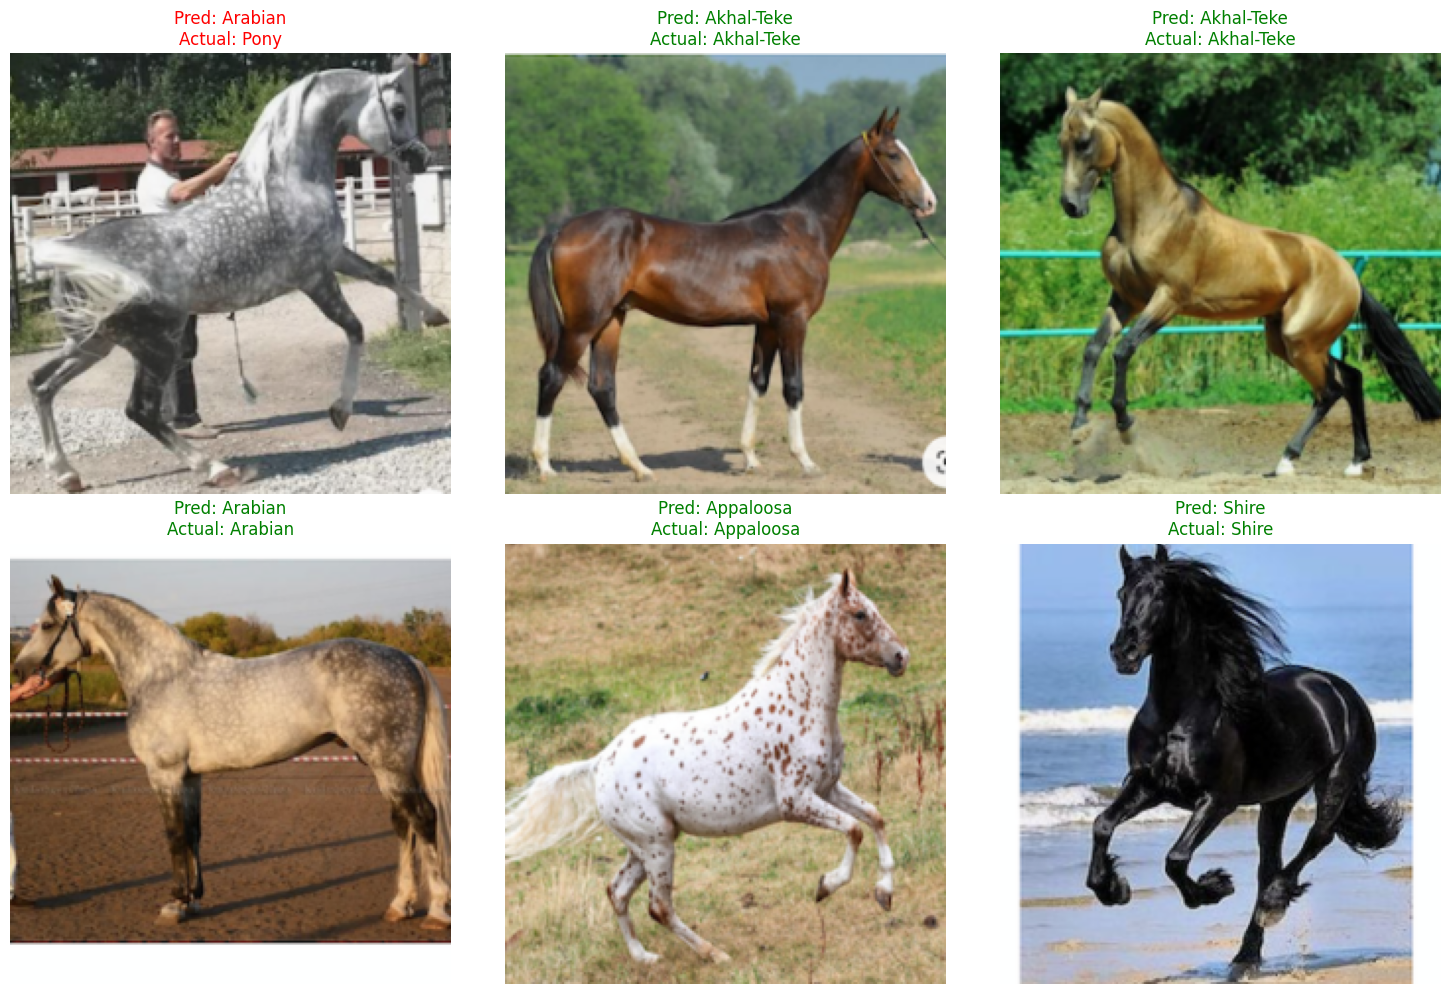

In [24]:
horse_breeds = ['Akhal-Teke', 'Appaloosa', 'Arabian', 'Friesian', 'Percheron', 'Pony', 'Shire']
loss_fn_vit, opt_vit, sched_vit = training_tools(model_vit, lr=1e-4)

vit_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_loss = float('inf')

print(f"Starting Training \n")

for epoch in range(10):
    t_loss, t_acc = train_function(model_vit, train_dataloader, loss_fn_vit, opt_vit, device)
    v_loss, v_acc, v_f1 = validate_function(model_vit, val_dataloader, loss_fn_vit, device)
    
    sched_vit.step()

    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(model_vit.state_dict(), 'best_vit_model.pth')
        save_msg = " | Model Saved"
    else:
        save_msg = ""

    vit_history['train_loss'].append(t_loss)
    vit_history['train_acc'].append(t_acc)
    vit_history['val_loss'].append(v_loss)
    vit_history['val_acc'].append(v_acc)
    vit_history['val_f1'].append(v_f1)
    
    print(f"Epoch {epoch+1}/10:")
    print(f"Train Loss: {t_loss:.4f} | Train Accuracy: {t_acc:.2f}%")
    print(f"Val Loss: {v_loss:.4f} | Val Accuracy: {v_acc:.2f}%{save_msg}")
    print("-" * 30)

print("\n--- Final Evaluation ---")
model_vit.load_state_dict(torch.load('best_vit_model.pth'))
test_acc_vit, test_f1_vit = test_function(model_vit, test_dataloader, device)

plot_history(vit_history, "Vision Transformer")
visualize_predictions(model_vit, test_dataloader, device, horse_breeds)

### Algorithm 3: EfficientNet

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_eff = models.efficientnet_b0(weights='DEFAULT').to(device)

for param in model_eff.parameters():
    param.requires_grad = False

model_eff.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Linear(512, 7)
).to(device)

print("EfficientNet-B0 initialized.")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 137MB/s] 


EfficientNet-B0 initialized.


Starting Training 

Epoch 1/10:
Train Loss: 1.4427 | Train Accuracy: 55.56%
Val Loss: 0.8674 | Val Accuracy: 73.27% | Model Saved
------------------------------
Epoch 2/10:
Train Loss: 0.7543 | Train Accuracy: 76.28%
Val Loss: 0.6843 | Val Accuracy: 74.26% | Model Saved
------------------------------
Epoch 3/10:
Train Loss: 0.5667 | Train Accuracy: 81.20%
Val Loss: 0.6091 | Val Accuracy: 77.23% | Model Saved
------------------------------
Epoch 4/10:
Train Loss: 0.4927 | Train Accuracy: 82.26%
Val Loss: 0.6347 | Val Accuracy: 72.28%
------------------------------
Epoch 5/10:
Train Loss: 0.4222 | Train Accuracy: 86.11%
Val Loss: 0.5035 | Val Accuracy: 86.14% | Model Saved
------------------------------
Epoch 6/10:
Train Loss: 0.4332 | Train Accuracy: 84.83%
Val Loss: 0.5503 | Val Accuracy: 80.20%
------------------------------
Epoch 7/10:
Train Loss: 0.3590 | Train Accuracy: 87.82%
Val Loss: 0.5451 | Val Accuracy: 80.20%
------------------------------
Epoch 8/10:
Train Loss: 0.2687 | Tr

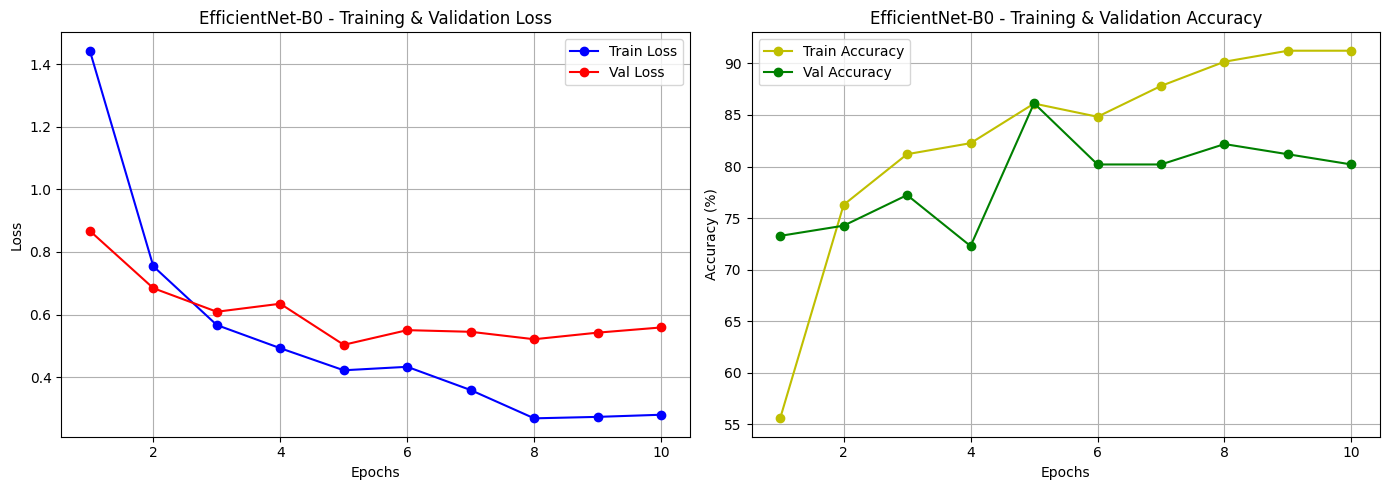

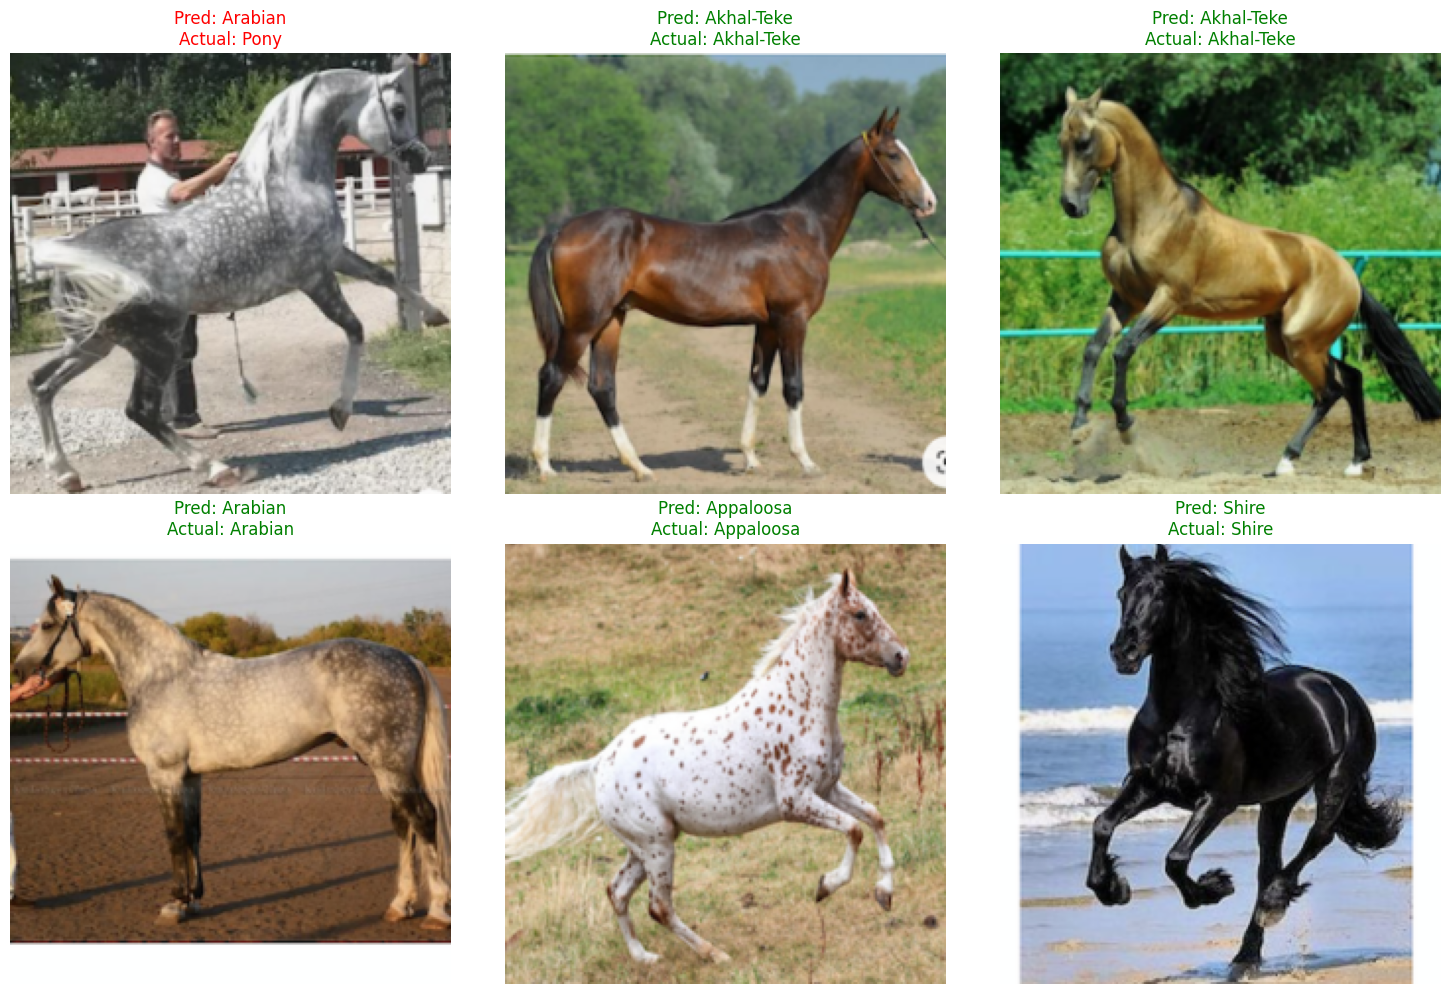

In [16]:
horse_breeds = ['Akhal-Teke', 'Appaloosa', 'Arabian', 'Friesian', 'Percheron', 'Pony', 'Shire']
loss_fn_eff, opt_eff, sched_eff = training_tools(model_eff, lr=1e-3)

eff_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_loss = float('inf')

print(f"Starting Training \n")

for epoch in range(10):
    t_loss, t_acc = train_function(model_eff, train_dataloader, loss_fn_eff, opt_eff, device)
    v_loss, v_acc, v_f1 = validate_function(model_eff, val_dataloader, loss_fn_eff, device)
    
    sched_eff.step()

    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(model_eff.state_dict(), 'best_eff_model.pth')
        save_msg = " | Model Saved"
    else:
        save_msg = ""

    eff_history['train_loss'].append(t_loss)
    eff_history['train_acc'].append(t_acc)
    eff_history['val_loss'].append(v_loss)
    eff_history['val_acc'].append(v_acc)
    eff_history['val_f1'].append(v_f1)
    
    print(f"Epoch {epoch+1}/10:")
    print(f"Train Loss: {t_loss:.4f} | Train Accuracy: {t_acc:.2f}%")
    print(f"Val Loss: {v_loss:.4f} | Val Accuracy: {v_acc:.2f}%{save_msg}")
    print("-" * 30)


print("\n--- Final Evaluation ---")
model_eff.load_state_dict(torch.load('best_eff_model.pth'))
test_function(model_eff, test_dataloader, device)

plot_history(eff_history, "EfficientNet-B0")
visualize_predictions(model_eff, test_dataloader, device, horse_breeds)

### Final Comparison Table

In [25]:
import pandas as pd


cnn_acc, cnn_f1 = test_function(model_cnn, test_dataloader, device)
vit_acc, vit_f1 = test_function(model_vit, test_dataloader, device)
eff_acc, eff_f1 = test_function(model_eff, test_dataloader, device)


data = {
    'Model': ['SimpleCNN', 'Vision Transformer (ViT)', 'EfficientNet-B0'],
    'Test Accuracy (%)': [cnn_acc, vit_acc, eff_acc],
    'Test F1-Score': [cnn_f1, vit_f1, eff_f1],
    'Training Type': ['From Scratch', 'Transfer Learning (Frozen)', 'Transfer Learning (Frozen)']
}


df_compare = pd.DataFrame(data)
df_compare = df_compare.sort_values(by='Test Accuracy (%)', ascending=False)

print("--- Model Performance Comparison ---")
print(df_compare.to_string(index=False))


--- Final Test Results ---
Test Accuracy: 56.44%
Test F1-Score: 0.5424

--- Final Test Results ---
Test Accuracy: 83.17%
Test F1-Score: 0.8209

--- Final Test Results ---
Test Accuracy: 86.14%
Test F1-Score: 0.8569
--- Model Performance Comparison ---
                   Model  Test Accuracy (%)  Test F1-Score              Training Type
         EfficientNet-B0          86.138614       0.856867 Transfer Learning (Frozen)
Vision Transformer (ViT)          83.168317       0.820862 Transfer Learning (Frozen)
               SimpleCNN          56.435644       0.542354               From Scratch
